In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [10]:
cd /content/drive/MyDrive/NewDeepLearning/CNN/

/content/drive/MyDrive/NewDeepLearning/CNN


# Import


In [3]:
import cupy as np
import pickle
import cv2 as cv
import matplotlib.pyplot as plt
from mnist import load_mnist
from optimizer import *
#from simple_convnet import SimpleConvNet
from collections import OrderedDict
from layers import *


# 3conv2pool CNN Network

In [ ]:
# coding: utf-8



class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - conv - relu - pool - conv - relu - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def save_params(self, file_name="params.pkl"):
      params = {}
      for key, val in self.params.items():
          params[key] = val
      with open(file_name, 'wb') as f:
          pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
      with open(file_name, 'rb') as f:
          params = pickle.load(f)
      for key, val in params.items():
          self.params[key] = val

      for i, layer_idx in enumerate(("Conv1", "Conv2","Conv3", "Affine1", "Affine2")):
          self.layers[layer_idx].W = self.params['W' + str(i+1)]
          self.layers[layer_idx].b = self.params['b' + str(i+1)]

# The trainning model
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_num_2 = filter_num*2
        filter_num_3 = filter_num_2*2

        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]

        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int((filter_num_3/4) * int((conv_output_size/2)) * int((conv_output_size/2)))
        #conv_2_output_size = (pool_output_size - filter_size+ 2*filter_pad)/filter_stride + 1
        #pool_2_output_size = int((filter_num_2/4) * (conv_2_output_size/4) * (conv_2_output_size/4))


        # 重みの初期化
        self.params = {}
        self.weight_init_std = np.sqrt(2 / 784)
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(filter_num_2, filter_num, filter_size,filter_size)
        self.params['b2'] = np.zeros(filter_num_2)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(filter_num_3,filter_num_2, filter_size,filter_size)
        self.params['b3'] = np.zeros(filter_num_3)
        self.params['W4'] = weight_init_std * \
                            np.random.randn(pool_output_size,hidden_size)
        self.params['b4'] = np.zeros(hidden_size)
        self.params['W5'] = weight_init_std * \
                            np.random.randn(hidden_size,output_size)
        self.params['b5'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu2'] = Relu()
        self.layers['Pool2'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv3'] = Convolution(self.params['W3'], self.params['b3'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu3'] = Relu()
        self.layers['Affine1'] = Affine(self.params['W4'], self.params['b4'])
        self.layers['Relu4'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W5'], self.params['b5'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def predict_1(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        y = softmax(x)
        y = np.argmax(y, axis=1)
        return y  
    

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]


    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W3'], grads['b3'] = self.layers['Conv3'].dW, self.layers['Conv3'].db
        grads['W4'], grads['b4'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W5'], grads['b5'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


# 4conv3pool CNN Network

In [4]:
# coding: utf-8



class SimpleConvNet:
    """単純なConvNet


    conv - relu - pool - conv - relu - pool - conv - relu - pool - conv - relu - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
# The trainning model
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_num_2 = filter_num*2
        filter_num_3 = filter_num_2*2
        filter_num_4 = filter_num_3*2

        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]

        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int((filter_num_4) * int((conv_output_size/8)) * int((conv_output_size/8)))
        #conv_2_output_size = (pool_output_size - filter_size+ 2*filter_pad)/filter_stride + 1
        #pool_2_output_size = int((filter_num_2/4) * (conv_2_output_size/4) * (conv_2_output_size/4))


        # 重みの初期化
        self.params = {}
        #self.weight_init_std = np.sqrt(2 / 784)
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(filter_num_2, filter_num, filter_size,filter_size)
        self.params['b2'] = np.zeros(filter_num_2)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(filter_num_3,filter_num_2, filter_size,filter_size)
        self.params['b3'] = np.zeros(filter_num_3)
        self.params['W4'] = weight_init_std * \
                            np.random.randn(filter_num_4,filter_num_3, filter_size,filter_size)
        self.params['b4'] = np.zeros(filter_num_4)
        self.params['W5'] = weight_init_std * \
                            np.random.randn(pool_output_size,hidden_size)
        self.params['b5'] = np.zeros(hidden_size)
        self.params['W6'] = weight_init_std * \
                            np.random.randn(hidden_size,output_size)
        self.params['b6'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu2'] = Relu()
        self.layers['Pool2'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv3'] = Convolution(self.params['W3'], self.params['b3'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu3'] = Relu()
        self.layers['Pool3'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv4'] = Convolution(self.params['W4'], self.params['b4'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu4'] = Relu()
        self.layers['Affine1'] = Affine(self.params['W5'], self.params['b5'])
        self.layers['Relu5'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W6'], self.params['b6'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def predict_1(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        y = softmax(x)
        y = np.argmax(y, axis=1)
        return y  
    

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]


    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W3'], grads['b3'] = self.layers['Conv3'].dW, self.layers['Conv3'].db
        grads['W4'], grads['b4'] = self.layers['Conv4'].dW, self.layers['Conv4'].db
        grads['W5'], grads['b5'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W6'], grads['b6'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    
    def save_params(self, file_name="params.pkl"):
      params = {}
      for key, val in self.params.items():
          params[key] = val
      with open(file_name, 'wb') as f:
          pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
      with open(file_name, 'rb') as f:
          params = pickle.load(f)
      for key, val in params.items():
          self.params[key] = val

      for i, layer_idx in enumerate(("Conv1", "Conv2","Conv3","Conv4", "Affine1", "Affine2")):
          self.layers[layer_idx].W = self.params['W' + str(i+1)]
          self.layers[layer_idx].b = self.params['b' + str(i+1)]


# Mẫu bộ dữ liệu huấn luyện

(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


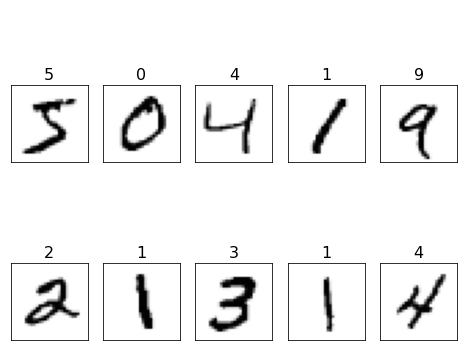

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

n_data = 10
row = 2
col = 5
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))

fig.suptitle("MNIST data-set", fontsize=24, color='white')
for i, img in enumerate(x_train[:n_data]):
    _r = i // col
    _c = i % col
    ax[_r,_c].set_title(t_train[i], fontsize=16, color='black')
    ax[_r,_c].axes.xaxis.set_visible(False)
    ax[_r,_c].axes.yaxis.set_visible(False)
    ax[_r,_c].imshow(img.reshape(28, 28), cmap='Greys')

plt.show()
plt.close()

# Train


In [7]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

epoch:0, train acc:0.09035, test acc:0.0892
epoch:1, train acc:0.9706666666666667, test acc:0.9713
epoch:2, train acc:0.9832166666666666, test acc:0.9823
epoch:3, train acc:0.9888, test acc:0.988
epoch:4, train acc:0.9879166666666667, test acc:0.9859
epoch:5, train acc:0.9932, test acc:0.9907
epoch:6, train acc:0.9953666666666666, test acc:0.9911
epoch:7, train acc:0.99335, test acc:0.9899
epoch:8, train acc:0.9946833333333334, test acc:0.9903
epoch:9, train acc:0.9963166666666666, test acc:0.9918


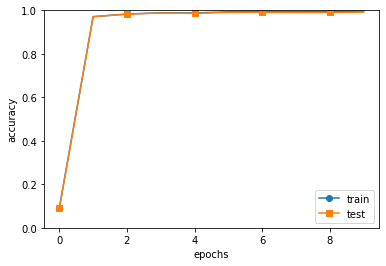

'\nprint(x_train.shape)\nprint(t_train.shape)\nprint(x_test.shape)\nprint(t_test.shape)\n\nn_data = 20\nrow = 4\ncol = 5\nfig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))\n\nfig.suptitle("MNIST data-set", fontsize=24, color=\'white\')\nfor i, img in enumerate(x_train[:n_data]):\n    _r = i // col\n    _c = i % col\n    ax[_r,_c].set_title(t_train[i], fontsize=16, color=\'black\')\n    ax[_r,_c].axes.xaxis.set_visible(False)\n    ax[_r,_c].axes.yaxis.set_visible(False)\n    ax[_r,_c].imshow(img.reshape(28, 28), cmap=\'Greys\')\n\nplt.show()\nplt.close()\n'

In [8]:
# coding: utf-8



# 0:Load MNIST data
#(x_train, t_train), (x_test, t_test) = load_mnist(normalize=False, one_hot_label=False)
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

# 1:Settings
network = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 32, 'filter_size': 3, 'pad': 1, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
optimizer = Adam()   #SGD(lr=0.01)
max_epochs = 10
train_size = x_train.shape[0]
batch_size = 100
iter_per_epoch = max(train_size / batch_size, 1)
max_iter = int(max_epochs * iter_per_epoch)

train_loss_list = []
train_acc_list = []
test_acc_list = []

epoch_cnt = 0

for i in range(max_iter):
    batch_mask = np.random.choice(train_size, batch_size).get()
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(np.asarray(x_batch), np.asarray(t_batch))
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(np.asarray(x_train), np.asarray(t_train))
        test_acc = network.accuracy(np.asarray(x_test), np.asarray(t_test))
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            network.save_params()
            break


# Plot
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x.get(), np.asarray(train_acc_list).get(), marker='o', label='train', markevery=2)
plt.plot(x.get(), np.asarray(test_acc_list).get(), marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
"""
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

n_data = 20
row = 4
col = 5
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))

fig.suptitle("MNIST data-set", fontsize=24, color='white')
for i, img in enumerate(x_train[:n_data]):
    _r = i // col
    _c = i % col
    ax[_r,_c].set_title(t_train[i], fontsize=16, color='black')
    ax[_r,_c].axes.xaxis.set_visible(False)
    ax[_r,_c].axes.yaxis.set_visible(False)
    ax[_r,_c].imshow(img.reshape(28, 28), cmap='Greys')

plt.show()
plt.close()
"""


(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


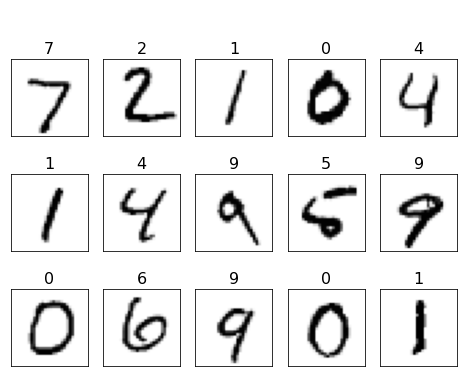

In [9]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

n_data = 15
row = 3
col = 5
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))

fig.suptitle("MNIST data-set", fontsize=24, color='white')
for i, img in enumerate(x_test[:n_data]):
    _r = i // col
    _c = i % col
    ax[_r,_c].set_title(t_test[i], fontsize=16, color='black')
    ax[_r,_c].axes.xaxis.set_visible(False)
    ax[_r,_c].axes.yaxis.set_visible(False)
    ax[_r,_c].imshow(img.reshape(28, 28), cmap='Greys')

plt.show()
plt.close()

# Using HandWriting Data (Edited)

In [ ]:
model = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 32, 'filter_size': 3, 'pad': 1, 'stride': 1},
                        hidden_size=100, output_size=10)
model.load_params()

img1 = cv.imread('/content/drive/MyDrive/NewDeepLearning/CNN/Yuda-handwriting/06935.jpg')
img2 = cv.imread('/content/drive/MyDrive/NewDeepLearning/CNN/Yuda-handwriting/31356.jpg')

plt.figure(figsize =(20, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.imshow(img1)
ax2 = plt.subplot(1, 2, 2)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax2.imshow(img2)

# Cần phải có ảnh (28,28) để chạy model
# Nhưng vì có 5 số dính với nhau nên resize thành (28,28*5)
img1=cv.resize(img1, dsize=(28*5,28)) # Size ảnh lúc này là (28,28,3) (3 là chiều sâu ảnh)
img2=cv.resize(img2, dsize=(28*5,28))
# Nối 2 ảnh thành 1
img = cv.hconcat([img1, img2])

# Lúc này img có size là (28,28*10,3), ta chuyển xám nó để thành (28,28*10)
dst=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
# Hàm này xem ở sile 15, file: 13.DL-Practice.pptx
(ret,dst) = cv.threshold(dst, 165, 0, cv.THRESH_TOZERO_INV)

img_original = []
img_edited = []
for i in range(1, 11):
  # img[0:28, 28*(i-1):28*i] dùng để cắt từng ảnh ra
  img_original.append(img[0:28, 28*(i-1):28*i])
  img_edited.append(dst[0:28, 28*(i-1):28*i])
  img_edited[i-1] = np.reshape(img_edited[i-1], (1, 28,28))

pre = model.predict_1(np.asarray(img_edited))

row = 2
col = 10
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(20, 5))

for i in range(10):
  _r = i // col
  _c = i % col
  ax[_r,_c].set_title(str(pre[i]), fontsize=16, color='black')
  ax[_r,_c].axes.xaxis.set_visible(False)
  ax[_r,_c].axes.yaxis.set_visible(False)
  ax[_r,_c].imshow(img_original[i])

for i in range(10):
  _r = i // col + 1
  _c = i % col
  ax[_r,_c].set_title(str(pre[i]), fontsize=16, color='black')
  ax[_r,_c].axes.xaxis.set_visible(False)
  ax[_r,_c].axes.yaxis.set_visible(False)
  ax[_r,_c].imshow(img_edited[i].reshape(28, 28), cmap='Greys')

plt.show()
plt.close()

this is using 3conv2pool and epoch 20.
samething happen with 4conv3pool and epoch 20.
At the last run i run it with 4Conv3pool and epoch 10.


# YuDa's HandWriting


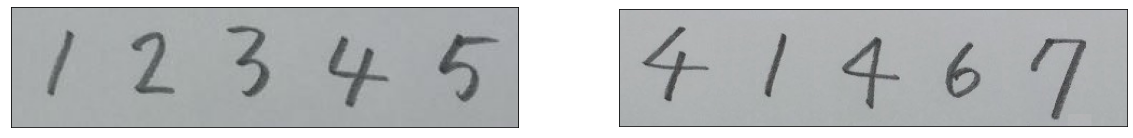

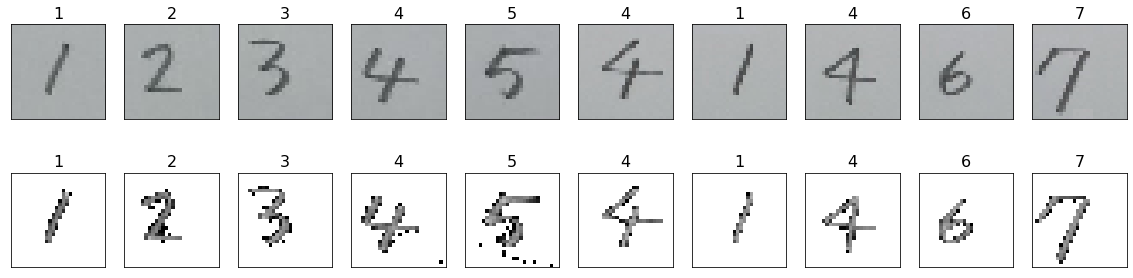

In [9]:
model = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 32, 'filter_size': 3, 'pad': 1, 'stride': 1},
                        hidden_size=100, output_size=10)
model.load_params()

img1 = cv.imread('/content/drive/MyDrive/NewDeepLearning/CNN/Yuda-handwriting/12345.jpg')
img2 = cv.imread('/content/drive/MyDrive/NewDeepLearning/CNN/Yuda-handwriting/41467.png')

plt.figure(figsize =(20, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.imshow(img1)
ax2 = plt.subplot(1, 2, 2)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax2.imshow(img2)

# Cần phải có ảnh (28,28) để chạy model
# Nhưng vì có 5 số dính với nhau nên resize thành (28,28*5)
img1=cv.resize(img1, dsize=(28*5,28)) # Size ảnh lúc này là (28,28,3) (3 là chiều sâu ảnh)
img2=cv.resize(img2, dsize=(28*5,28))
# Nối 2 ảnh thành 1
img = cv.hconcat([img1, img2])

# Lúc này img có size là (28,28*10,3), ta chuyển xám nó để thành (28,28*10)
dst=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
# Hàm này xem ở sile 15, file: 13.DL-Practice.pptx
(ret,dst) = cv.threshold(dst, 165, 0, cv.THRESH_TOZERO_INV)

img_original = []
img_edited = []
for i in range(1, 11):
  # img[0:28, 28*(i-1):28*i] dùng để cắt từng ảnh ra
  img_original.append(img[0:28, 28*(i-1):28*i])
  img_edited.append(dst[0:28, 28*(i-1):28*i])
  img_edited[i-1] = np.reshape(img_edited[i-1], (1, 28,28))

pre = model.predict_1(np.asarray(img_edited))

row = 2
col = 10
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(20, 5))

for i in range(10):
  _r = i // col
  _c = i % col
  ax[_r,_c].set_title(str(pre[i]), fontsize=16, color='black')
  ax[_r,_c].axes.xaxis.set_visible(False)
  ax[_r,_c].axes.yaxis.set_visible(False)
  ax[_r,_c].imshow(img_original[i])

for i in range(10):
  _r = i // col + 1
  _c = i % col
  ax[_r,_c].set_title(str(pre[i]), fontsize=16, color='black')
  ax[_r,_c].axes.xaxis.set_visible(False)
  ax[_r,_c].axes.yaxis.set_visible(False)
  ax[_r,_c].imshow(img_edited[i].reshape(28, 28), cmap='Greys')

plt.show()
plt.close()